In this notebook, I want to assess the accuracy of the trained model.
This is done by evaluating the energy of configurations in the test set.
The predicted energies are compared to the DFT calculated energies in a parity plot.

Additionally, I also want to look at the uncertainty of the energy predictions, evaluated using different member in the ensemble.

In [1]:
from pathlib import Path
import json
import os
import pickle
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

from ase.io import read
from ase.calculators.kim import KIM

%matplotlib inline
plt.style.use("default")

In [2]:
# Read setting file
WORK_DIR = Path().absolute()
ROOT_DIR = WORK_DIR.parent
DATA_DIR = ROOT_DIR / "data"
with open(ROOT_DIR / "settings.json", "r") as f:
    settings = json.load(f)
partition = settings["partition"]
PART_DIR = DATA_DIR / f"{partition}_partition_data"
FP_DIR = PART_DIR / "fingerprints"
RES_DIR = WORK_DIR / "results" / f"{partition}_partition"
if not RES_DIR.exists():
    RES_DIR.mkdir(parents=True)

# Get the reference energy data

In [3]:
uncertainty_energy_file = RES_DIR / "uncertainty_energy.pkl"
if uncertainty_energy_file.exists():
    with open(uncertainty_energy_file, "rb") as f:
        configs_dict = pickle.load(f)
    structures = list(configs_dict)
else:
    # Get all test configurations
    configs_dict = {}

    dataset_dir = PART_DIR / "carbon_test_set"
    structures = os.listdir(dataset_dir)
    for struct in structures:
        substructures = os.listdir(dataset_dir / struct)
        configs_dict.update({struct: {"identifier": []}})

        if os.path.isdir(subdir / os.listdir(subdir)[0]):
            # The configurations are stored inside the subsubdirectory
            substructures = os.listdir(subdir)
            for substruct in substructures:
                configs = os.listdir(subdir / substruct)
                configs_paths = [str(subdir / substruct / cc) for cc in configs]
                configs_dict[struct]["identifier"].extend(configs_paths)
        else:
            # The configurations are stored inside the subdirectory
            configs = os.listdir(subdir)
            configs_paths = [str(subdir / cc) for cc in configs]
            configs_dict[struct]["identifier"].extend(configs_paths)

    # Get the reference data and predictions
    for struct in structures:
        identifiers = configs_dict[struct]["identifier"]
        nid = len(identifiers)
        energies = []
        natoms = []
        preds = np.zeros((100, nid))
        for ii, path in tqdm(enumerate(identifiers), desc=struct, total=nid):
            atoms = read(path)
            # Reference energy
            energies = np.append(energies, atoms.info["Energy"])
            natoms = np.append(natoms, atoms.get_global_number_of_atoms())
            # Predicted energy ensembles
            for ii, path in tqdm(enumerate(identifiers), desc=struct, total=nid):
                for jj in tqdm(range(100)):
                    atoms.calc = KIM(f"DUNN_C_bootstrap_{jj:03d}")
                    preds[jj, ii] = atoms.get_potential_energy()
        configs_dict[struct].update(
            {"energy": energies, "natoms": natoms, "prediction": preds}
        )

        with open(uncertainty_energy_file, "wb") as f:
            pickle.dump(configs_dict, f, protocol=4)

# Plot

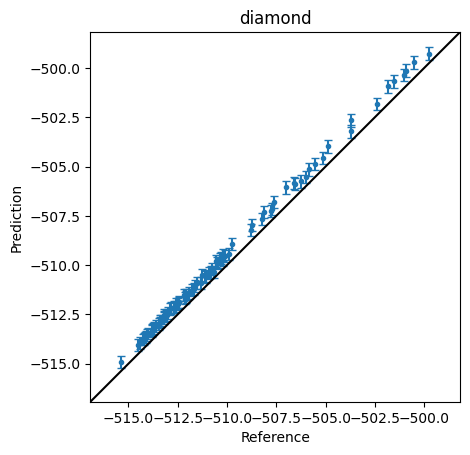

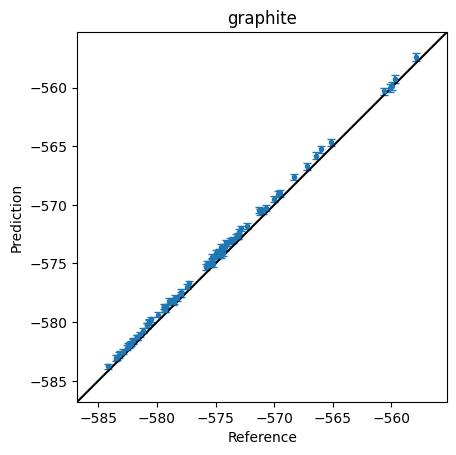

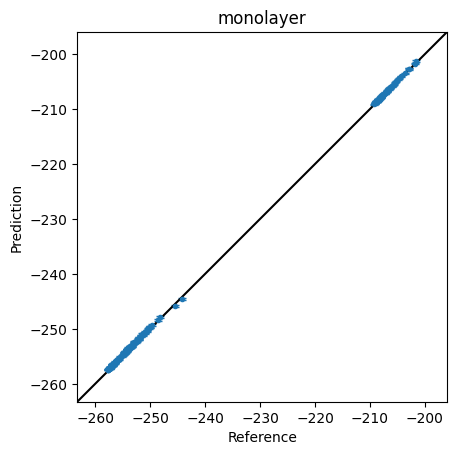

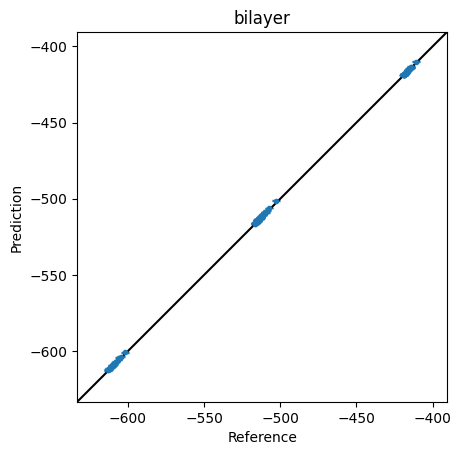

In [4]:
# Parity plot each structure separately
for structure in structures:
    # Get the data
    ref_eng = configs_dict[structure]["energy"]
    natoms = configs_dict[structure]["natoms"]
    ens_eng = configs_dict[structure]["prediction"]
    ens_eng_mean = np.mean(ens_eng, axis=0)
    ens_eng_err = np.std(ens_eng, axis=0)

    # Some plotting constants
    xdata = ref_eng
    ydata = ens_eng_mean
    eng_max = np.max(xdata)
    eng_min = np.min(xdata)
    eng_range = eng_max - eng_min
    axis_min = eng_min - 0.1 * eng_range
    axis_max = eng_max + 0.1 * eng_range

    # Plot
    plt.figure()
    plt.title(structure)
    plt.errorbar(xdata, ydata, ens_eng_err, fmt=".", capsize=3)
    plt.plot([axis_min, axis_max], [axis_min, axis_max], c="k")
    plt.xlim(axis_min, axis_max)
    plt.ylim(axis_min, axis_max)
    plt.xlabel("Reference")
    plt.ylabel("Prediction")
    plt.gca().set_aspect("equal")
plt.show()

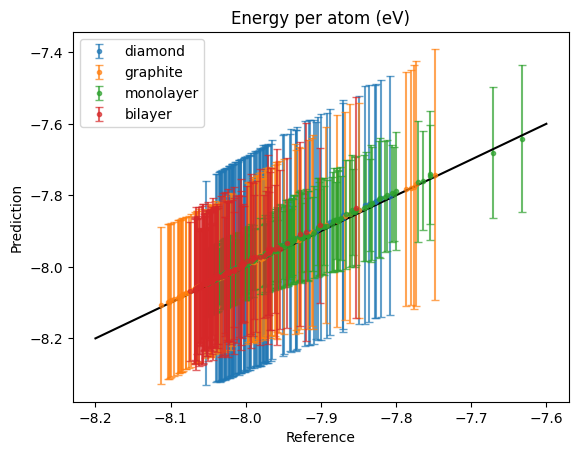

In [5]:
# Combined parity plot, normalize the energy by the number of atoms in each structure.
plt.figure()
plt.title("Energy per atom (eV)")
for structure in structures:
    # Get the data
    ref_eng = configs_dict[structure]["energy"]
    natoms = configs_dict[structure]["natoms"]
    ens_eng = configs_dict[structure]["prediction"]
    ens_eng_mean = np.mean(ens_eng, axis=0)
    ens_eng_err = np.std(ens_eng, axis=0)

    # Some plotting constants
    xdata = ref_eng / natoms
    ydata = ens_eng_mean / natoms
    eng_max = np.max([xdata, ydata])
    eng_min = np.min([xdata, ydata])
    eng_range = eng_max - eng_min
    axis_min = eng_min - 0.1 * eng_range
    axis_max = eng_max + 0.1 * eng_range

    # Plot
    plt.errorbar(
        xdata, ydata, ens_eng_err, fmt=".", capsize=3, alpha=0.7, label=structure
    )

plt.plot([-8.2, -7.6], [-8.2, -7.6], c="k")
plt.xlabel("Reference")
plt.ylabel("Prediction")
plt.legend()
plt.show()

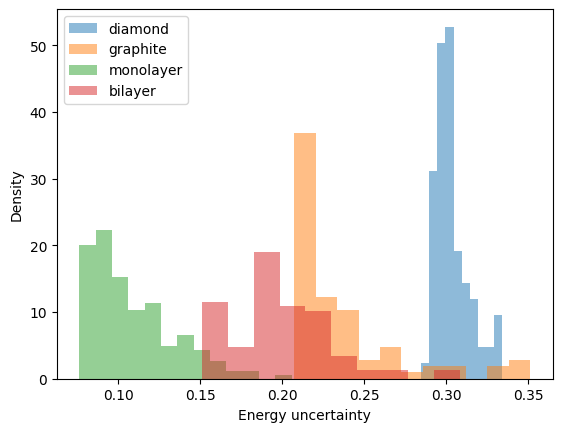

In [6]:
# Histogram of the energy uncertainty
plt.figure()
for structure in structures:
    # Get the data
    ens_eng = configs_dict[structure]["prediction"]
    ens_eng_err = np.std(ens_eng, axis=0)

    # Plot
    plt.hist(ens_eng_err, density=True, bins="auto", alpha=0.5, label=structure)

plt.xlabel("Energy uncertainty")
plt.ylabel("Density")
plt.legend()
plt.show()

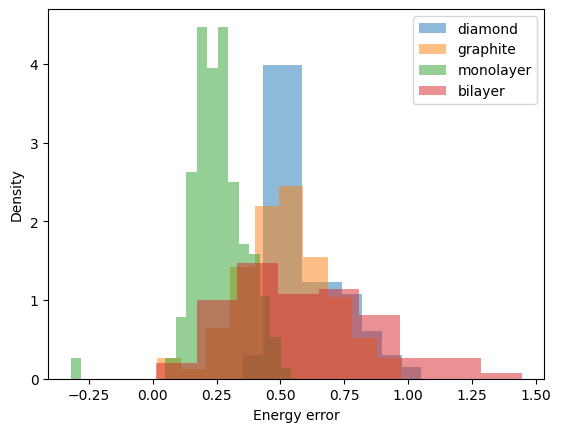

In [7]:
# Histogram of the energy error
plt.figure()
for structure in structures:
    # Get the data
    ref_eng = configs_dict[structure]["energy"]
    natoms = configs_dict[structure]["natoms"]
    ens_eng = configs_dict[structure]["prediction"]
    ens_eng_mean = np.mean(ens_eng, axis=0)

    # Plot
    plt.hist(
        (ens_eng_mean - ref_eng), density=True, bins="auto", alpha=0.5, label=structure
    )

plt.xlabel("Energy error")
plt.ylabel("Density")
plt.legend()
plt.show()

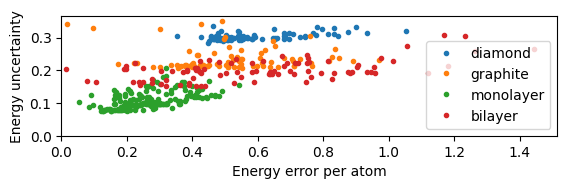

In [8]:
# Energy error vs energy uncertainty
plt.figure()
for structure in structures:
    # Get the data
    ref_eng = configs_dict[structure]["energy"]
    natoms = configs_dict[structure]["natoms"]
    ens_eng = configs_dict[structure]["prediction"]
    ens_eng_mean = np.mean(ens_eng, axis=0)
    ens_eng_std = np.std(ens_eng, axis=0)
    eng_err = np.abs(ens_eng_mean - ref_eng)

    # Plot
    plt.plot(eng_err, ens_eng_std, ".", label=structure)

plt.xlabel("Energy error per atom")
plt.ylabel("Energy uncertainty")
plt.xlim(left=0.0)
plt.ylim(bottom=0.0)
plt.gca().set_aspect(1)
plt.legend()
plt.show()